In [1]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers

In [2]:
# Define the path to the data folder
data_folder = "./lego_parts"

In [3]:
# Define the list of available classes (part numbers)
classes = os.listdir(data_folder)
classes.remove('.DS_Store')

In [4]:
# Create image datasets using TensorFlow's image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_folder,
    labels="inferred",
    label_mode="int",
    class_names=classes,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_folder,
    labels="inferred",
    label_mode="int",
    class_names=classes,
    validation_split=0.15,
    subset="validation",
    seed=123,
    image_size=(64, 64),
    batch_size=32
)

train_ds,test_ds=tf.keras.utils.split_dataset(
    train_ds, left_size=None, right_size=.15,
)

Found 28000 files belonging to 7 classes.
Using 22400 files for training.
Found 28000 files belonging to 7 classes.
Using 4200 files for validation.
['3700', '32607', '2420', '6536', '3032', '2450', '99207']


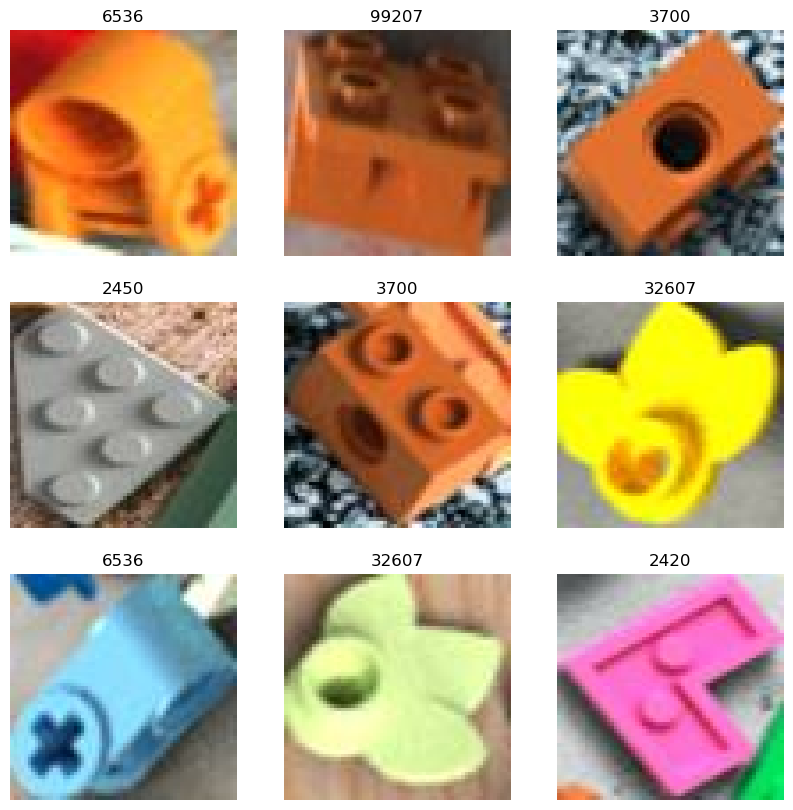

In [5]:
# Plot the first 9 images in the training dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")
plt.show()

In [6]:
# Normalize the pixel values of images to [0, 1]
normalization_layer = layers.Rescaling(1./255)

In [7]:
# Define our custom model architecture
our_model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(64, 64, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(len(classes), activation='softmax')
])

In [8]:
# Defince train and evaluate functions with saving
def train_and_evaluate_model(model_name, model):
    print(f"Training and evaluating {model_name}...")
    model = tf.keras.models.clone_model(model)
    model.compile(optimizer=adam,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    checkpoint_path = f"./best/best_model_{model_name}.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, checkpoint_callback]
    )

    eval_results = model.evaluate(test_ds)

    trained_models[model_name] = {
        "model": model,
        "train_accuracy": history.history['accuracy'][-1],
        "val_accuracy": history.history['val_accuracy'][-1],
        "test_accuracy": eval_results[1],
        "train_loss": history.history['loss'][-1],
        "val_loss": history.history['val_loss'][-1],
        "test_loss": eval_results[0]
    }

    model.save(f"./models/trained_model_{model_name}.h5")

In [10]:
# Define the models list
models = [
    ("Our model", our_model),
    ("VGG16", tf.keras.applications.VGG16(weights=None, input_shape=(64, 64, 3), classes=len(classes))),
    ("VGG19", tf.keras.applications.VGG19(weights=None, input_shape=(64, 64, 3), classes=len(classes))),
    ("DenseNet121", tf.keras.applications.DenseNet121(weights=None, input_shape=(64, 64, 3), classes=len(classes))),
    ("DenseNet169", tf.keras.applications.DenseNet169(weights=None, input_shape=(64, 64, 3), classes=len(classes))),
    ("DenseNet201", tf.keras.applications.DenseNet201(weights=None, input_shape=(64, 64, 3), classes=len(classes))),
]

In [11]:
# Define the number of epochs and the Adam optimizer
epochs = 100
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Define trained_models dictionary
trained_models = {}

for model_name, model in models:
    train_and_evaluate_model(model_name, model)

Training and evaluating Our model...
Epoch 1/100
592/595 [============================>.] - ETA: 0s - loss: 1.8889 - accuracy: 0.2304
Epoch 1: val_accuracy improved from -inf to 0.48833, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_Our model.h5
595/595 [==============================] - 11s 18ms/step - loss: 1.8869 - accuracy: 0.2315 - val_loss: 1.5333 - val_accuracy: 0.4883
Epoch 2/100
  7/595 [..............................] - ETA: 10s - loss: 1.6609 - accuracy: 0.3929

/Users/jakubsutowski/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


594/595 [============================>.] - ETA: 0s - loss: 1.4099 - accuracy: 0.4664
Epoch 2: val_accuracy improved from 0.48833 to 0.60714, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_Our model.h5
595/595 [==============================] - 11s 18ms/step - loss: 1.4093 - accuracy: 0.4666 - val_loss: 1.2159 - val_accuracy: 0.6071
Epoch 3/100
593/595 [============================>.] - ETA: 0s - loss: 1.1710 - accuracy: 0.5628
Epoch 3: val_accuracy improved from 0.60714 to 0.64214, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_Our model.h5
595/595 [==============================] - 11s 18ms/step - loss: 1.1706 - accuracy: 0.5628 - val_loss: 1.1016 - val_accuracy: 0.6421
Epoch 4/100
595/595 [==============================] - ETA: 0s - loss: 1.0568 - accuracy: 0.6093
Epoch 4: val_accuracy improved from 0.64214 to 0.65429, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_Our model.h5
595/595 [==============================] - 11s 

Epoch 1/100
595/595 [==============================] - ETA: 0s - loss: 1.7146 - accuracy: 0.2693
Epoch 1: val_accuracy improved from -inf to 0.53167, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_VGG16.h5
595/595 [==============================] - 79s 131ms/step - loss: 1.7146 - accuracy: 0.2693 - val_loss: 1.2156 - val_accuracy: 0.5317
Epoch 2/100
595/595 [==============================] - ETA: 0s - loss: 0.9903 - accuracy: 0.6123
Epoch 2: val_accuracy improved from 0.53167 to 0.72405, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_VGG16.h5
595/595 [==============================] - 79s 133ms/step - loss: 0.9903 - accuracy: 0.6123 - val_loss: 0.7353 - val_accuracy: 0.7240
Epoch 3/100
595/595 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.8019
Epoch 3: val_accuracy improved from 0.72405 to 0.83262, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_VGG16.h5
595/595 [==============================] - 78s 1

Training and evaluating VGG19...
Epoch 1/100
595/595 [==============================] - ETA: 0s - loss: 1.9466 - accuracy: 0.1472
Epoch 1: val_accuracy improved from -inf to 0.13762, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_VGG19.h5
595/595 [==============================] - 95s 158ms/step - loss: 1.9466 - accuracy: 0.1472 - val_loss: 1.9464 - val_accuracy: 0.1376
Epoch 2/100
595/595 [==============================] - ETA: 0s - loss: 1.9461 - accuracy: 0.1397
Epoch 2: val_accuracy did not improve from 0.13762
595/595 [==============================] - 93s 156ms/step - loss: 1.9461 - accuracy: 0.1397 - val_loss: 1.9462 - val_accuracy: 0.1376
Epoch 3/100
595/595 [==============================] - ETA: 0s - loss: 1.9463 - accuracy: 0.1416
Epoch 3: val_accuracy did not improve from 0.13762
595/595 [==============================] - 94s 158ms/step - loss: 1.9463 - accuracy: 0.1416 - val_loss: 1.9466 - val_accuracy: 0.1376
Epoch 4/100
595/595 [======================

Epoch 1/100
595/595 [==============================] - ETA: 0s - loss: 1.3912 - accuracy: 0.4537
Epoch 1: val_accuracy improved from -inf to 0.50857, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_DenseNet121.h5
595/595 [==============================] - 99s 144ms/step - loss: 1.3912 - accuracy: 0.4537 - val_loss: 1.3600 - val_accuracy: 0.5086
Epoch 2/100
595/595 [==============================] - ETA: 0s - loss: 0.9293 - accuracy: 0.6481
Epoch 2: val_accuracy improved from 0.50857 to 0.67024, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_DenseNet121.h5
595/595 [==============================] - 81s 136ms/step - loss: 0.9293 - accuracy: 0.6481 - val_loss: 0.8703 - val_accuracy: 0.6702
Epoch 3/100
595/595 [==============================] - ETA: 0s - loss: 0.6566 - accuracy: 0.7646
Epoch 3: val_accuracy improved from 0.67024 to 0.71500, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_DenseNet121.h5
595/595 [=====================

Epoch 1/100
595/595 [==============================] - ETA: 0s - loss: 1.3947 - accuracy: 0.4512
Epoch 1: val_accuracy improved from -inf to 0.46690, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_DenseNet169.h5
595/595 [==============================] - 145s 214ms/step - loss: 1.3947 - accuracy: 0.4512 - val_loss: 1.4376 - val_accuracy: 0.4669
Epoch 2/100
595/595 [==============================] - ETA: 0s - loss: 0.9478 - accuracy: 0.6401
Epoch 2: val_accuracy improved from 0.46690 to 0.63667, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_DenseNet169.h5
595/595 [==============================] - 108s 181ms/step - loss: 0.9478 - accuracy: 0.6401 - val_loss: 0.9443 - val_accuracy: 0.6367
Epoch 3/100
595/595 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.7572
Epoch 3: val_accuracy improved from 0.63667 to 0.73929, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_DenseNet169.h5
595/595 [===================

Epoch 1/100
595/595 [==============================] - ETA: 0s - loss: 1.4392 - accuracy: 0.4307
Epoch 1: val_accuracy improved from -inf to 0.43524, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_DenseNet201.h5
595/595 [==============================] - 183s 261ms/step - loss: 1.4392 - accuracy: 0.4307 - val_loss: 1.6606 - val_accuracy: 0.4352
Epoch 2/100
595/595 [==============================] - ETA: 0s - loss: 0.9694 - accuracy: 0.6329
Epoch 2: val_accuracy improved from 0.43524 to 0.57167, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_DenseNet201.h5
595/595 [==============================] - 130s 218ms/step - loss: 0.9694 - accuracy: 0.6329 - val_loss: 1.2181 - val_accuracy: 0.5717
Epoch 3/100
595/595 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.7486
Epoch 3: val_accuracy improved from 0.57167 to 0.69286, saving model to /Users/jakubsutowski/Desktop/LEGO2/best/best_model_DenseNet201.h5
595/595 [===================

In [12]:
# Save results to a CSV file
results_df = pd.DataFrame.from_dict(trained_models, orient='index')
results_df.to_csv("./trained_models_results.csv")

In [13]:
# Load DataFrame with results
results_df = pd.read_csv("./trained_models_results.csv", index_col=0)
results_df

,model,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,test_loss
Our model,<keras.src.engine.sequential.Sequential object...,0.823529,0.715000,0.744940,0.757517,1.366874,0.956708
VGG16,<keras.src.engine.functional.Functional object...,0.861555,0.902857,0.908929,0.446065,0.412609,0.310846
VGG19,<keras.src.engine.functional.Functional object...,0.142017,0.137619,0.144048,1.946232,1.946462,1.945976
DenseNet121,<keras.src.engine.functional.Functional object...,0.982090,0.859048,0.868750,0.051858,0.532174,0.480999
DenseNet169,<keras.src.engine.functional.Functional object...,0.980200,0.809048,0.824405,0.059382,0.778169,0.652907
DenseNet201,<keras.src.engine.functional.Functional object...,0.991702,0.882381,0.885714,0.026702,0.496945,0.460075


In [14]:
# Remove VGG19 (worst model) from the DataFrame
results_df.drop('VGG19', inplace=True)

In [15]:
# Sort the DataFrame by test accuracy
results_df.sort_values(by=['test_accuracy'], ascending=False, inplace=True)

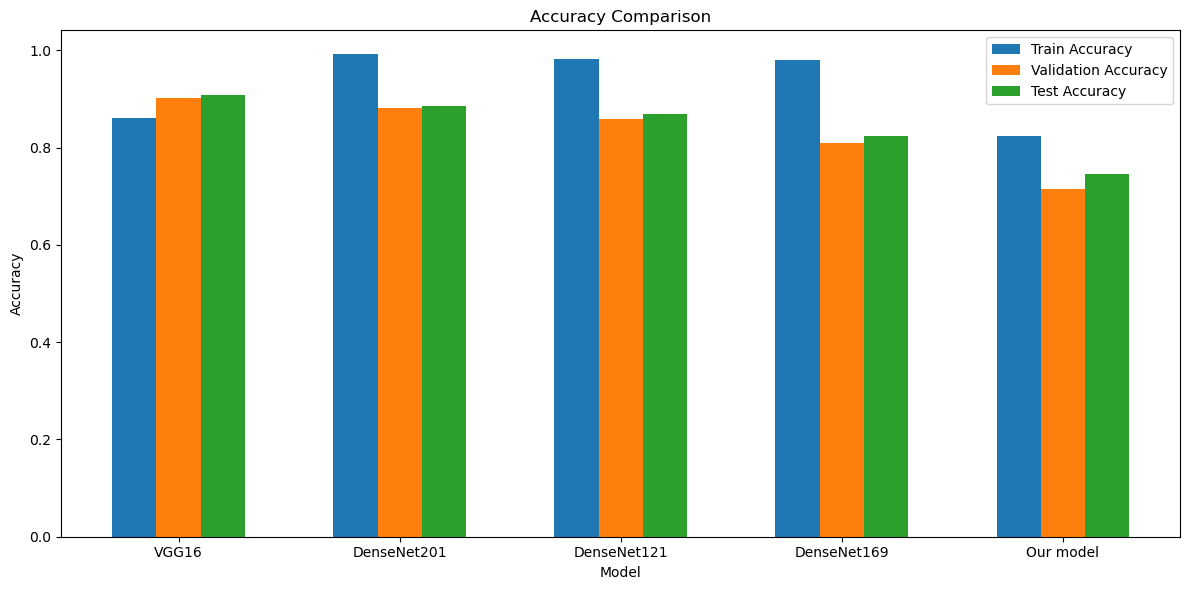

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of model names
models_list = results_df.index.tolist()

# Compare the accuracy of the models
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(models_list))

plt.bar(index, results_df['train_accuracy'], bar_width, label='Train Accuracy')
plt.bar(index + bar_width, results_df['val_accuracy'], bar_width, label='Validation Accuracy')
plt.bar(index + 2 * bar_width, results_df['test_accuracy'], bar_width, label='Test Accuracy')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(index + bar_width, models_list)
plt.legend()
plt.tight_layout()
plt.show()

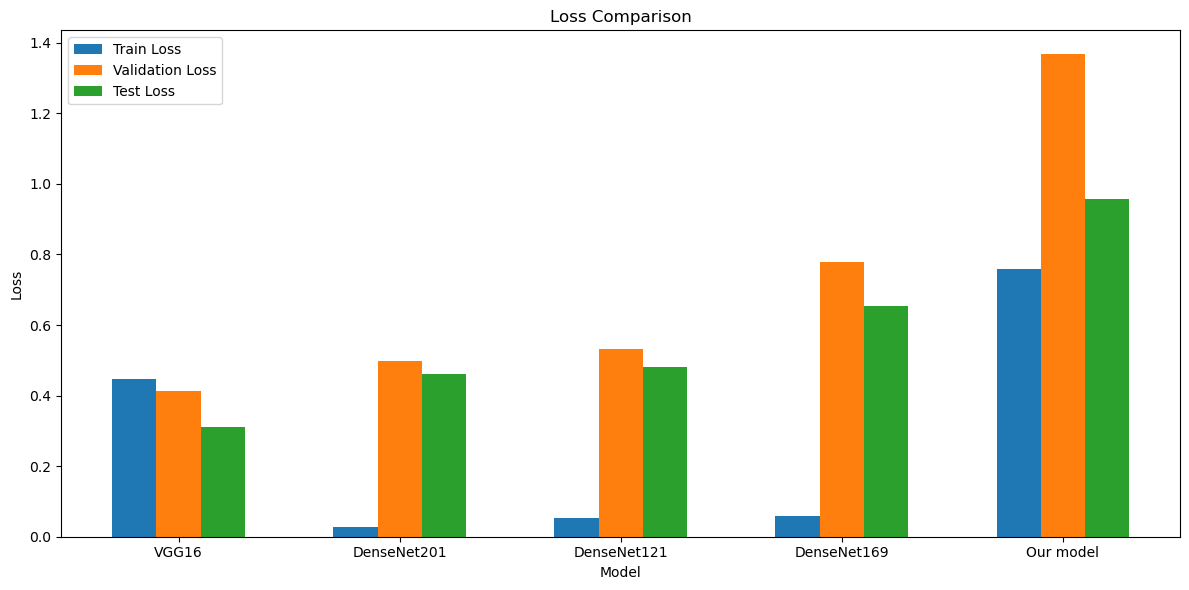

In [17]:
# Compare the loss of the models
plt.figure(figsize=(12, 6))

plt.bar(index, results_df['train_loss'], bar_width, label='Train Loss')
plt.bar(index + bar_width, results_df['val_loss'], bar_width, label='Validation Loss')
plt.bar(index + 2 * bar_width, results_df['test_loss'], bar_width, label='Test Loss')

plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.xticks(index + bar_width, models_list)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Load the best model
best_model = tf.keras.models.load_model('./best/best_model_VGG16.h5')

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Get labels from the test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Perform predictions on the test dataset
predictions = best_model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Get class names
class_names = classes

# Generate classification report with class names
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("\nClassification Report:")
print(report)

105/105 [==============================] - 3s 28ms/step

Classification Report:
              precision    recall  f1-score   support

        3700       0.94      0.89      0.92       476
       32607       0.85      0.88      0.87       484
        2420       0.88      0.90      0.89       485
        6536       0.83      0.91      0.87       468
        3032       0.98      0.97      0.97       499
        2450       0.98      0.93      0.95       476
       99207       0.93      0.87      0.90       472

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360



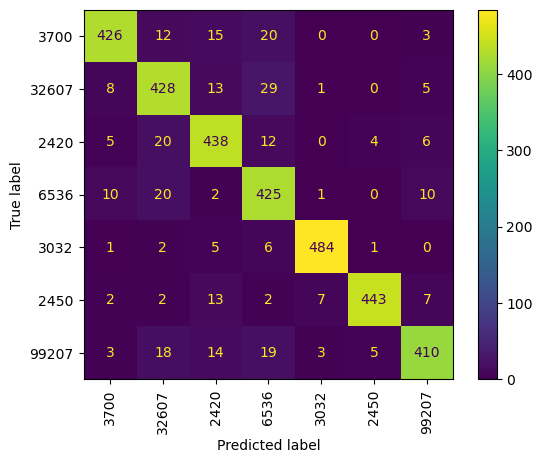

In [20]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(xticks_rotation="vertical")
plt.grid(False)

In [21]:
import cv2
import numpy as np

# Load the path to the test image
test_image_path = "./lego_parts/32607/14.jpg"

# Read the test image
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (64, 64))
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0

# Load the trained model
#best_model = tf.keras.models.load_model("./best/best_model_VGG16.h5")

# Perform prediction
predictions = best_model.predict(test_image)
predicted_class_index = np.argmax(predictions[0])

# Assuming you have a list called `class_names` with the names of the classes
class_names = classes

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Display the prediction result
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 1s 628ms/step
Predicted class: 32607
